# Hello Object Detection

A very basic introduction to using object detection models with OpenVINO™.

The [horizontal-text-detection-0001](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/horizontal-text-detection-0001/README.md) model from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. It detects horizontal text in images and returns a blob of data in the shape of `[100, 5]`. Each detected text box is stored in the `[x_min, y_min, x_max, y_max, conf]` format, where the
`(x_min, y_min)` are the coordinates of the top left bounding box corner, `(x_max, y_max)` are the coordinates of the bottom right bounding box corner and `conf` is the confidence for the predicted class.

## Imports

In [1]:
import openvino as ov
import cv2
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

## Available inference device
device from dropdown list for running inference using OpenVINO

In [2]:
core = ov.Core()
options = core.available_devices
options

['CPU', 'GPU']

## Load the Model


In [3]:
model = core.read_model(model="model/horizontal-text-detection-0001.xml")
compiled_model = core.compile_model(model=model, device_name='CPU')

input_layer = compiled_model.input(0)
output_layer = compiled_model.output("boxes")

print(input_layer.shape)

[1,3,704,704]


## Load an Image

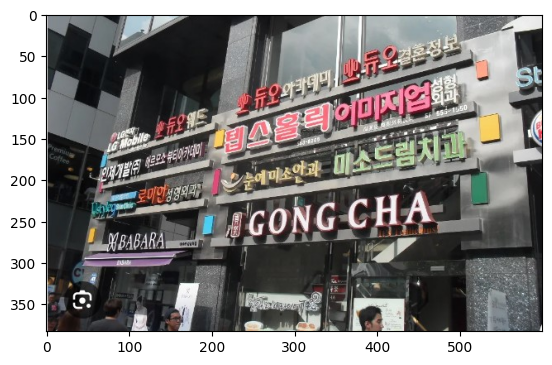

In [8]:
# Text detection models expect an image in BGR format.
image = cv2.imread("data/rnb.jpg")
#print(image.shape)

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))
#print(resized_image.shape)

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
#print(input_image.shape)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## Do Inference

In [9]:
# Create an inference request.
boxes = compiled_model([input_image])[output_layer]

# Remove zero only boxes.(100개 중에 0이 있는 것 삭제)
boxes = boxes[~np.all(boxes == 0, axis=1)]

## Visualize Results

In [10]:
# For each detection, the description is in the [x_min, y_min, x_max, y_max, conf] format:
# The image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib, use cvtColor function
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],       # (516,690)
        resized_image.shape[:2],   # (704,704)
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y, 10)) if idx % 2 else int(corner_position * ratio_x)) for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

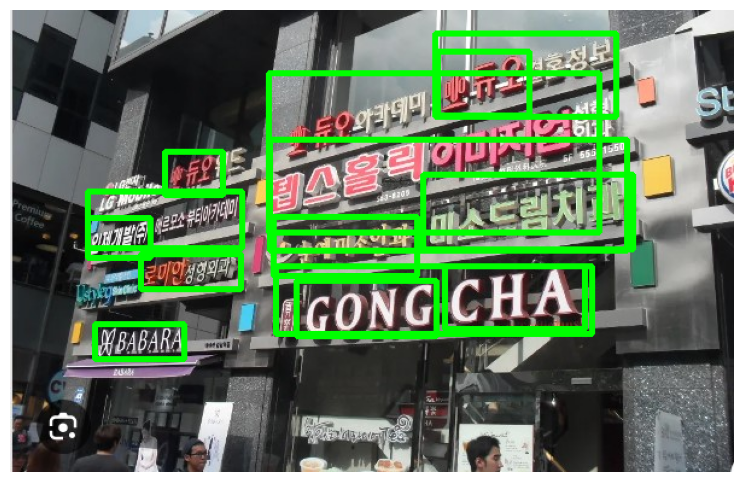

In [12]:
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=False));

## 6. 배포

###  Gradio

In [13]:
import openvino as ov
import cv2
import numpy as np

from pathlib import Path
import PIL
import gradio as gr

In [14]:
core = ov.Core()
options = core.available_devices
options

['CPU', 'GPU']

In [15]:
model = core.read_model(model="model/horizontal-text-detection-0001.xml")
compiled_model = core.compile_model(model=model, device_name='CPU')

input_layer = compiled_model.input(0)
output_layer = compiled_model.output("boxes")

In [46]:
def preprocess(image):

    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    N, C, H, W = input_layer.shape
    resized_image = cv2.resize(image, (W, H))
    input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
    
    return input_image, resized_image 

In [47]:
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],       # 517, 690
        resized_image.shape[:2],   #704, 704
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    # rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y, 10)) if idx % 2 else int(corner_position * ratio_x)) for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(bgr_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

In [50]:
def predict_image(image):
    input_image, resized_image = preprocess(image)  #이미지 shape 전처리 
    
    boxes = compiled_model([input_image])[output_layer]
    boxes = boxes[~np.all(boxes == 0, axis=1)]
    canvas = convert_result_to_image(image, resized_image, boxes, conf_labels=True)
    
    return canvas

In [52]:
demo = gr.Interface(predict_image, gr.Image(), "image")
demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
